# MODELAGEM POR TÓPICOS - DADOS MINISTÉRIO DA SAÚDE

## Importando o BD & Inicializando variáveis

In [3]:
!pip install pyLDAvis
import pandas as pd
import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 15.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=d8e1884af15fa59ba1fae77514f77b0e8f300565a347cc6e402d08a22a40ab36
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=09788a74538eaf38f7de9ed48255e679e9ebba7f133699b0ab275452edb95abd
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pyLDAvis sklearn


In [ ]:
## opcao de leitura do arquivo direto do nosso diretorio compartilhado no gdrive ##
from google.colab import drive
drive.mount('/content/drive/')
path_drive = '/content/drive/My Drive/IC - Matheus/'
path_datasets = path_drive + 'Datasets/'
path_models = path_drive + 'Códigos/Modelos/'
ENTITY = 'MINSAUDE'

Mounted at /content/drive/


In [ ]:
# número de tópicos escolhido
num_topics = 20

In [ ]:
## arquivos que serão gerados / lidos
LDAvis_data_filepath = os.path.join(path_models + ENTITY + '_ldavis_prepared_'+str(num_topics))
LDAvis_html_filepath = os.path.join(LDAvis_data_filepath + '.html')
lda_model_filepath = os.path.join(path_models + ENTITY + '_lda_model_' + str(num_topics))
corpus_filepath = os.path.join(path_models + ENTITY + '_corpus_' + str(num_topics))
id2word_filepath = os.path.join(path_models + ENTITY + '_id2word_' + str(num_topics))

keys_unicas = os.path.join(path_models + ENTITY + '_Keys_unicas_' + str(num_topics) + '.xlsx')
keys_todas = os.path.join(path_models + ENTITY + '_Keys_Todas_' + str(num_topics) + '.xlsx')

covid_dataset_final = os.path.join(path_models + ENTITY + '_coviddatasetfinal_' + str(num_topics) + '.csv')

In [ ]:
df = pd.read_csv(path_datasets + 'dataset_minsaude.csv', encoding='utf8')

In [ ]:
covid = df
len(covid)

3020

## Pré-processamento dos dados

In [ ]:
import os
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


stop_words = set(stopwords.words('portuguese'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#Acrescentarei manualmente a palavra "sobre" às stop words, pois não é relevante e estava ocorrendo muito

list_stop_words = ['sobre', 'ser', 'ministerio', 'saude', 'ministério', 'saúde']

stop_words.update(list_stop_words)

In [ ]:
#Criaremos a função para pré processamento dos dados

def preprocess(raw_text):
    
    #Expressão regular para manter apenas letras no texto 
    letters_only_text = re.sub("[^a-zA-ZãõÃÕçÇáéíóúÁÉÍÓÚâêîôûÂÊÎÔÛ]", " ", raw_text) #DUVIDA: COMO RESUMIR ESSE CÓDIGO? OU FIZ CERTO? COMO REMOVER O \n TAMBÉM

    #Converter o texto todo para minúsculo e fazer um split -> convert string into list ( 'hello world' -> ['hello', 'world'])
    words = letters_only_text.lower().split()

    cleaned_words = []
    
    #remover stopwords
    for word in words:
      if word not in stop_words:
        cleaned_words.append(word)
    
    #transformar a lista em uma string novamente
    return " ".join(cleaned_words)

In [ ]:
#Substitui os vazios da coluna full_content pelo texto do summary (onde tinha summary)

for i in range(0,len(covid)):
  if (pd.isnull(covid['full_content'][i])):
    covid['full_content'][i] = covid['summary'][i]

covid = covid[covid['full_content'].notnull()]
covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2968 entries, 0 to 3019
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    2968 non-null   int64 
 1   title         2968 non-null   object
 2   created       2968 non-null   object
 3   link          2968 non-null   object
 4   summary       2065 non-null   object
 5   full_created  2962 non-null   object
 6   full_content  2968 non-null   object
dtypes: int64(1), object(6)
memory usage: 185.5+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
covid['prep'] = covid['full_content'].apply(preprocess) #cria uma nova coluna 'prep' que trará os dados pré processados, removendo pontos e stop words

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
covid.iloc[0,7]

'incluiu campo medicamentos antineoplásicos informados tela dados complementares quimioterapia autorização procedimentos ambulatoriais apac portaria trouxe alterações publicada diário oficial união nessa semana objetivo obter informações precisas medicamentos utilizados tratamento pacientes câncer medida pasta irá monitorar avaliar resultados tratamento pacientes maneira eficiente disponibilizada lista medicamentos antineoplásicos correspondente deverão selecionados campo específico registrados sistema informação ambulatorial datasus acordo esquema terapêutico câncer definido equipe médica responsável medida coordenada departamento atenção especializada temática daet secretaria atenção especializada saes diretora daet maíra botelho melhoria padronização instrumento registro certamente contribuirá qualificação informações consequente análise avaliação resultados tratamentos pacientes câncer necessitam cuidado tratamento câncer pode incluir cirurgia quimioterapia radioterapia transplante

In [ ]:
covid.iloc[0,6]

'\nO Ministério da Saúde incluiu o campo "Medicamentos Antineoplásicos Informados" na tela de dados complementares de quimioterapia da Autorização de Procedimentos Ambulatoriais (APAC). A portaria que trouxe as alterações foi publicada no Diário Oficial da União nessa semana. O objetivo é obter informações mais precisas sobre os medicamentos utilizados no tratamento dos pacientes com câncer.\nCom a medida, a Pasta irá monitorar e avaliar os resultados do tratamento dos pacientes de maneira mais eficiente. Será disponibilizada uma lista de medicamentos antineoplásicos correspondente que deverão ser selecionados em um campo específico e registrados nos Sistema de Informação Ambulatorial do DataSUS de acordo com o esquema terapêutico do câncer definido pela equipe médica responsável.\nA medida foi coordenada pelo Departamento de Atenção Especializada e Temática (DAET), da Secretaria de Atenção Especializada à Saúde (SAES), do Ministério. Para a diretora do DAET, Maíra Botelho, a melhoria 

In [ ]:
covid.head(1)

,Unnamed: 0,title,created,link,summary,full_created,full_content,prep
0,0,Ministério da Saúde promove melhoria no sistem...,08/01/2022,https://www.gov.br/saude/pt-br/assuntos/notici...,Informação sobre antineoplásicos no SUS passa ...,08/01/2022 18h50,"\nO Ministério da Saúde incluiu o campo ""Medic...",incluiu campo medicamentos antineoplásicos inf...


## Processo para criação dos tópicos

**======= INIT: Do not run the following cells =======**

In [ ]:
#Convertendo o objeto tokenizado em um corpus e dicionário

import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = covid.prep.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['incluiu', 'campo', 'medicamentos', 'antineoplasicos', 'informados', 'tela', 'dados', 'complementares', 'quimioterapia', 'autorizacao', 'procedimentos', 'ambulatoriais', 'apac', 'portaria', 'trouxe', 'alteracoes', 'publicada', 'diario', 'oficial', 'uniao', 'nessa', 'semana', 'objetivo', 'obter', 'informacoes', 'precisas', 'medicamentos', 'utilizados', 'tratamento', 'pacientes']


In [ ]:
# Build bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form trigrams
data_words = make_trigrams(data_words)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
import gensim.corpora as corpora

#Criando um dicionário
id2word = corpora.Dictionary(data_words)

# filter by frequency
id2word.filter_extremes(no_below=5, no_above=0.95)

#Criando um "corpus"
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 3), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 5), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [ ]:
dict(id2word) #Dicionário atribuindo um número a cada token

{0: 'acordo',
 1: 'alem',
 2: 'alta_complexidade',
 3: 'alta_complexidade_oncologia_cacon',
 4: 'alta_complexidade_oncologia_unacon',
 5: 'alteracoes',
 6: 'ambito',
 7: 'ambulatoriais',
 8: 'ambulatorial',
 9: 'analise',
 10: 'assistencia',
 11: 'atencao_especializada',
 12: 'atencao_especializada_saes',
 13: 'atencao_especializada_tematica',
 14: 'atender',
 15: 'autorizacao',
 16: 'avaliacao',
 17: 'avaliar',
 18: 'campo',
 19: 'cancer',
 20: 'casos',
 21: 'centro',
 22: 'certamente',
 23: 'cirurgia',
 24: 'complementares',
 25: 'composta',
 26: 'conforme',
 27: 'consequente',
 28: 'contribuira',
 29: 'controle',
 30: 'coordenada',
 31: 'correspondente',
 32: 'correspondentes',
 33: 'cuidado',
 34: 'custeio',
 35: 'dados',
 36: 'daet',
 37: 'datasus',
 38: 'definido',
 39: 'departamento',
 40: 'destas',
 41: 'devem',
 42: 'deverao',
 43: 'diretora',
 44: 'disponibilizada',
 45: 'diversas',
 46: 'eficiente',
 47: 'equipe',
 48: 'especifico',
 49: 'esquema_terapeutico',
 50: 'federais

### Valor da Coerência

O valor de coerência mede, dentro de um único tópico, a coerência semântica das palavras dentro dele, utilizando a métrica de cossenos para sua similaridade, que vai de 0 a 1. Este é um dos modelos de coerência (o c_v), existem outros, que não cabem a discussão neste post. Existem outros critérios para avaliar também modelagem de tópicos, como a perplexidade.

100%|██████████| 5/5 [02:35<00:00, 31.09s/it]


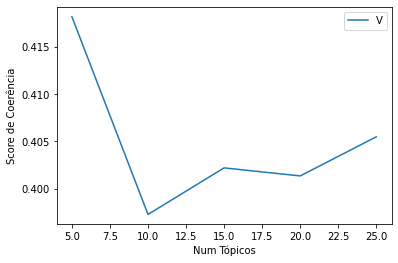

A quantidade de tópicos = 5  tem um valor de coerência de  0.4182
A quantidade de tópicos = 10  tem um valor de coerência de  0.3973
A quantidade de tópicos = 15  tem um valor de coerência de  0.4022
A quantidade de tópicos = 20  tem um valor de coerência de  0.4014
A quantidade de tópicos = 25  tem um valor de coerência de  0.4055


In [ ]:
from tqdm import tqdm
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# Função para determinar a melhor quantidade de tópicos para a modelagem
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        #model = LdaMulticore(corpus, id2word=id2word, num_topics=10)
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       iterations=200,
                                       random_state=500
                                       )
        model = lda_model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
# Mostrando visualmente a quantidade de tópicos
limit=30; start=5; step=5;

# Colocando parametros na função
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, 
                                                        start=start, limit=limit, step=step)

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Tópicos")
plt.ylabel("Score de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()
# Lista dos valores de coerência, para melhor identificar o ponto de inflexão do gráfico
for m, cv in zip(x, coherence_values):
    print("A quantidade de tópicos =", m, " tem um valor de coerência de ", round(cv, 4))

### Gerando o modelo final de tópicos

In [ ]:
from pprint import pprint

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       iterations=200,
                                       random_state=500
                                       )
# Print top-n keywords of each topic
pprint(lda_model.print_topics(num_words=20))
doc_lda = lda_model[corpus]

[(0,
  '0.009*"profissionais" + 0.009*"hospital" + 0.009*"covid" + 0.007*"mil" + '
  '0.006*"estados" + 0.006*"casos" + 0.006*"sus" + 0.005*"coronavirus" + '
  '0.005*"leitos" + 0.005*"brasil" + 0.005*"municipios" + 0.005*"populacao" + '
  '0.004*"nacional" + 0.004*"pacientes" + 0.004*"pais" + 0.004*"acoes" + '
  '0.004*"doenca" + 0.004*"milhoes" + 0.004*"atendimento" + 0.004*"todo"'),
 (1,
  '0.012*"milhoes" + 0.011*"casos" + 0.011*"brasil" + 0.009*"mil" + '
  '0.009*"municipios" + 0.008*"covid" + 0.008*"estados" + 0.007*"pais" + '
  '0.007*"profissionais" + 0.007*"pessoas" + 0.006*"populacao" + '
  '0.006*"atendimento" + 0.006*"coronavirus" + 0.006*"doenca" + 0.006*"doses" '
  '+ 0.005*"nacional" + 0.005*"sus" + 0.005*"todos" + 0.004*"total" + '
  '0.004*"todo"'),
 (2,
  '0.013*"milhoes" + 0.010*"covid" + 0.009*"doses" + 0.009*"sus" + '
  '0.008*"vacinas" + 0.008*"estados" + 0.007*"vacinacao" + 0.006*"municipios" '
  '+ 0.006*"mil" + 0.006*"informacoes" + 0.006*"pais" + 0.005*"nacion

In [ ]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.028594 -0.016745       1        1  12.509518
10     0.007512  0.015627       2        1   9.937453
4      0.035446  0.013443       3        1   9.265575
18     0.013762 -0.017736       4        1   8.314512
12     0.042313 -0.031200       5        1   8.303729
2      0.036212  0.005348       6        1   7.645542
19     0.028832  0.064968       7        1   6.795161
13     0.041128 -0.151851       8        1   5.806288
7     -0.030350 -0.007521       9        1   5.726099
8      0.073817  0.018411      10        1   4.519821
0     -0.022643 -0.015999      11        1   4.282417
14    -0.021489  0.008967      12        1   2.826161
16    -0.127408 -0.038249      13        1   2.307261
17     0.022335  0.056540      14        1   2.272853
11     0.017890 -0.017360      15        1   2.000447
6     -0.043734  0.062569      16        1   1.836392
3     -0.100591 -0.005242      17        1   1.648168
5      0.011408  0.010535      18        1   1.531409
9      0.003028  0.045310      19        1   1.266634
15    -0.016065  0.000186      20        1   1.204560, topic_info=            Term         Freq        Total Category  logprob  loglift
2031    hospital  1567.000000  1567.000000  Default  30.0000  30.0000
20         casos  4249.000000  4249.000000  Default  29.0000  29.0000
1665      leitos  2056.000000  2056.000000  Default  28.0000  28.0000
147        covid  4841.000000  4841.000000  Default  27.0000  27.0000
120   tratamento  1552.000000  1552.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
87          pais    21.812998  3042.462063  Topic20  -5.6968  -0.5189
324          mil    20.909063  3211.912601  Topic20  -5.7391  -0.6154
138         cada    19.077022  1490.231690  Topic20  -5.8308   0.0609
639         caso    17.690795   805.140721  Topic20  -5.9063   0.6011
209      pessoas    18.356842  2838.319441  Topic20  -5.8693  -0.6219

[1579 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1702      1  0.097792       acao
1702      2  0.125732       acao
1702      3  0.036672       acao
1702      4  0.045403       acao
1702      5  0.066359       acao
...     ...       ...        ...
8117     12  0.359055  wolbachia
8117     16  0.067323  wolbachia
8117     20  0.022441  wolbachia
7630      1  0.092683       york
7630     16  0.741467       york

[8347 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 11, 5, 19, 13, 3, 20, 14, 8, 9, 1, 15, 17, 18, 12, 7, 4, 6, 10, 16])

### Salvando modelo de tópicos treinado

In [ ]:
import pyLDAvis.gensim_models
import os
import pickle 
import pyLDAvis

# Visualize the topics
##pyLDAvis.enable_notebook()

##LDAvis_data_filepath = os.path.join(cwd+'/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    ##LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)


#pyLDAvis.save_html(LDAvis_prepared, cwd+'/ldavis_prepared_'+ str(num_topics) +'.html')
pyLDAvis.save_html(LDAvis_prepared, LDAvis_html_filepath)
##LDAvis_prepared

In [ ]:
a = lda_model.show_topics(formatted=False, num_words=20)
dict(a[0][1])

{'atendimento': 0.004983324,
 'brasil': 0.009861156,
 'casos': 0.0046897293,
 'coronavirus': 0.005161875,
 'covid': 0.014553831,
 'doses': 0.0069343424,
 'estados': 0.009432487,
 'leitos': 0.01424036,
 'mil': 0.005166601,
 'milhoes': 0.011273433,
 'municipios': 0.0065876255,
 'nacional': 0.0054471325,
 'pacientes': 0.0062348726,
 'pais': 0.0059073176,
 'pessoas': 0.0061625917,
 'populacao': 0.0064091748,
 'sus': 0.008067938,
 'todo': 0.0048656245,
 'vacinacao': 0.00527045,
 'vacinas': 0.004913175}

In [ ]:
chaves = list(dict(a[0][1]).keys())
minsaude = pd.DataFrame(chaves)
for i in range(1,11):
    minsaude[i] = minsaude[0]
    for j in range(0,20):
        palavra = chaves[j]
        if (palavra in dict(a[i-1][1])):
            minsaude[i][j] = dict(a[i-1][1])[palavra]
        else:
            minsaude[i][j] = 0

minsaude = minsaude.rename(columns={0: 'Key'})
minsaude       

,Key,1,2,3,4,5,6,7,8,9,10
0,covid,0.014554,0.011033,0.006874,0.008736,0.008025,0.006843,0.008241,0.008417,0.006693,0.012186
1,leitos,0.01424,0,0,0.010726,0,0,0,0,0,0
2,milhoes,0.011273,0.012427,0,0.006363,0.012032,0.004825,0.011398,0.004077,0.00971,0.005005
3,brasil,0.009861,0.009326,0.005754,0.006116,0.010983,0.007419,0.013748,0.009751,0.017183,0.006592
4,estados,0.009432,0.004522,0.006966,0.005866,0.007673,0.00827,0.007323,0,0.00676,0.006239
5,sus,0.008068,0,0.004019,0.00485,0.004874,0.004473,0,0,0,0.006315
6,doses,0.006934,0.009135,0,0,0.005766,0,0,0,0,0
7,municipios,0.006588,0,0,0.004557,0.008553,0.004056,0,0,0.005592,0.00562
8,populacao,0.006409,0.004586,0.004375,0,0.006229,0.005766,0.005343,0,0.009625,0.003603
9,pacientes,0.006235,0,0.004573,0.007992,0,0,0,0,0,0.004411


In [ ]:
pickle.dump(lda_model,open(lda_model_filepath,'wb'))
pickle.dump(corpus,open(corpus_filepath,'wb'))
pickle.dump(id2word,open(id2word_filepath,'wb'))

In [ ]:
#!pip install xlsxwriter
from openpyxl import load_workbook

# Usando o ExcelWriter, cria um doc .xlsx, usando engine='xlsxwriter'. Para abrir um arquivo existente, usar engine=openpyxl
writer = pd.ExcelWriter(keys_unicas, engine='openpyxl')

# Armazena cada df em uma planilha diferente do mesmo arquivo
minsaude.to_excel(writer, sheet_name='Min_Saude')

# Fecha o ExcelWriter e gera o arquivo .xlsx
writer.save()

In [ ]:
lista = []
colunas = []
for i in range(0,20):
    lista.append([])
    for j in range(0,10):
        lista[i].append(list(dict(a[j][1]).keys())[i])
        lista[i].append(list(dict(a[j][1]).values())[i])
    lista [i] = tuple(lista[i])

for i in range(1,11):
    colunas.append('Topic'+str(i))
    colunas.append('%'+str(i))
    
minsaude_total = pd.DataFrame(lista,columns=colunas)

In [ ]:
# Usando o ExcelWriter, cria um doc .xlsx, usando engine='xlsxwriter'. Para abrir um arquivo existente, usar engine=openpyxl
writer = pd.ExcelWriter(keys_todas, engine='openpyxl')

# Armazena cada df em uma planilha diferente do mesmo arquivo
minsaude_total.to_excel(writer, sheet_name='Min_Saude')

# Fecha o ExcelWriter e gera o arquivo .xlsx
writer.save()

**======= END: Do not run the previous cells =======**

## Load trained topic model

In [ ]:
import pickle

In [ ]:
lda_model = pickle.load(open(lda_model_filepath,'rb'))
corpus = pickle.load(open(corpus_filepath,'rb'))
id2word = pickle.load(open(id2word_filepath,'rb'))
LDAvis_prepared = pickle.load(open(LDAvis_data_filepath,'rb'))

In [ ]:
import pyLDAvis.gensim_models
import os
import pickle 
import pyLDAvis

pyLDAvis.enable_notebook()
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.028594 -0.016745       1        1  12.509518
10     0.007512  0.015627       2        1   9.937453
4      0.035446  0.013443       3        1   9.265575
18     0.013762 -0.017736       4        1   8.314512
12     0.042313 -0.031200       5        1   8.303729
2      0.036212  0.005348       6        1   7.645542
19     0.028832  0.064968       7        1   6.795161
13     0.041128 -0.151851       8        1   5.806288
7     -0.030350 -0.007521       9        1   5.726099
8      0.073817  0.018411      10        1   4.519821
0     -0.022643 -0.015999      11        1   4.282417
14    -0.021489  0.008967      12        1   2.826161
16    -0.127408 -0.038249      13        1   2.307261
17     0.022335  0.056540      14        1   2.272853
11     0.017890 -0.017360      15        1   2.000447
6     -0.043734  0.062569      16        1   1.836392
3     -0.100591 -0.005242      17        1   1.648168
5      0.011408  0.010535      18        1   1.531409
9      0.003028  0.045310      19        1   1.266634
15    -0.016065  0.000186      20        1   1.204560, topic_info=            Term         Freq        Total Category  logprob  loglift
2031    hospital  1567.000000  1567.000000  Default  30.0000  30.0000
20         casos  4249.000000  4249.000000  Default  29.0000  29.0000
1665      leitos  2056.000000  2056.000000  Default  28.0000  28.0000
147        covid  4841.000000  4841.000000  Default  27.0000  27.0000
120   tratamento  1552.000000  1552.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
87          pais    21.812998  3042.462063  Topic20  -5.6968  -0.5189
324          mil    20.909063  3211.912601  Topic20  -5.7391  -0.6154
138         cada    19.077022  1490.231690  Topic20  -5.8308   0.0609
639         caso    17.690795   805.140721  Topic20  -5.9063   0.6011
209      pessoas    18.356842  2838.319441  Topic20  -5.8693  -0.6219

[1579 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1702      1  0.097792       acao
1702      2  0.125732       acao
1702      3  0.036672       acao
1702      4  0.045403       acao
1702      5  0.066359       acao
...     ...       ...        ...
8117     12  0.359055  wolbachia
8117     16  0.067323  wolbachia
8117     20  0.022441  wolbachia
7630      1  0.092683       york
7630     16  0.741467       york

[8347 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 11, 5, 19, 13, 3, 20, 14, 8, 9, 1, 15, 17, 18, 12, 7, 4, 6, 10, 16])

In [ ]:
a = lda_model.show_topics(num_topics = num_topics,formatted=False, num_words=20)

In [ ]:
chaves = list(dict(a[0][1]).keys())
minsaude = pd.DataFrame(chaves)
for i in range(1,21):
    minsaude[i] = minsaude[0]
    for j in range(0,20):
        palavra = chaves[j]
        if (palavra in dict(a[i-1][1])):
            minsaude[i][j] = dict(a[i-1][1])[palavra]
        else:
            minsaude[i][j] = 0

minsaude = minsaude.rename(columns={0: 'Key'})
minsaude   

,Key,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,profissionais,0.009468,0.006918,0,0.003496,0.004242,0.006567,0.003367,0.00632,0,...,0.005775,0.004256,0,0.005437,0.004781,0,0,0.003714,0,0.005584
1,hospital,0.009456,0,0,0.022992,0,0,0,0.009786,0,...,0,0,0,0,0,0,0.021875,0,0,0
2,covid,0.008909,0.008025,0.010369,0.007151,0.011033,0.012186,0.006455,0.006843,0.006693,...,0.010084,0.006874,0.008241,0.015069,0.005473,0.008736,0,0.006343,0.014554,0
3,mil,0.007389,0.00946,0.006071,0,0,0.003536,0,0,0.006811,...,0,0.00664,0.004835,0.022656,0,0,0.003753,0,0.005167,0
4,estados,0.006317,0.007673,0.008408,0,0.004522,0.006239,0,0.00827,0.00676,...,0.004934,0.006966,0.007323,0.014245,0.007079,0.005866,0.006885,0.005394,0.009432,0
5,casos,0.005882,0.011253,0,0,0.00498,0.015152,0.006816,0.009357,0.01085,...,0.006663,0.0069,0.024782,0,0,0.004032,0,0.006254,0.00469,0.005238
6,sus,0.005517,0.004874,0.00887,0.007167,0,0.006315,0.008651,0.004473,0,...,0.005015,0.004019,0,0.008924,0.00715,0.00485,0.004152,0.00429,0.008068,0.005829
7,coronavirus,0.005357,0.006085,0,0.003117,0,0.008048,0.003688,0.007914,0,...,0.00497,0.008375,0.015246,0.007802,0,0,0,0,0.005162,0
8,leitos,0.005091,0,0.004318,0,0,0,0,0,0,...,0,0,0,0.008088,0.006369,0.010726,0.006215,0,0.01424,0
9,brasil,0.004981,0.010983,0.004733,0.004383,0.009326,0.006592,0,0.007419,0.017183,...,0.004804,0.005754,0.013748,0.011236,0.007013,0.006116,0.004442,0.008409,0.009861,0.008239


In [ ]:
lista = []
colunas = []
for i in range(0,20):
    lista.append([])
    for j in range(0,10):
        lista[i].append(list(dict(a[j][1]).keys())[i])
        lista[i].append(list(dict(a[j][1]).values())[i])
    lista [i] = tuple(lista[i])

for i in range(1,11):
    colunas.append('Topic'+str(i))
    colunas.append('%'+str(i))
    
minsaude_total = pd.DataFrame(lista,columns=colunas)

## Notícias mais representativas para cada tópico

In [ ]:
df = covid

In [ ]:
import numpy as np

def format_topics_sentences(idsnews, ldamodel=lda_model, corpus=corpus, texts=df):
    sent_topics_df = pd.DataFrame()

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                #if int(topic_num) == 3:
                #    print('*****')
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    ids = pd.Series(idsnews)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df = pd.concat([sent_topics_df, ids], axis=1)
    return(sent_topics_df)

idsnews = df.index.values
texts_full = covid.full_content.values.tolist()
df_topic_sents_keywords = format_topics_sentences(idsnews, ldamodel=lda_model, corpus=corpus, texts=texts_full)


df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Id']

#df_dominant_topic.head(20)

sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(10)], 
                                            axis=0)

sent_topics_sorteddf.reset_index(drop=True, inplace=True)

sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text", "Id"]

# Show
pd.options.display.max_colwidth = 300
pd.options.display.max_rows = 600
sent_topics_sorteddf.index = np.arange(1, len(sent_topics_sorteddf) + 1)
sent_topics_sorteddf['Topic_Num'] = sent_topics_sorteddf['Topic_Num'].apply(lambda x: x+1)
sent_topics_sorteddf_filtered = sent_topics_sorteddf[['Topic_Num', 'Topic_Perc_Contrib', 'Text', 'Id']]

topics_final = pd.DataFrame()

topics_final_grpd = sent_topics_sorteddf_filtered.groupby('Topic_Num')

for i, grp in topics_final_grpd:
    topics_final = pd.concat([topics_final, grp.sort_values(['Topic_Perc_Contrib'], ascending=[0]).head(5)], 
                                            axis=0)

topics_final.reset_index(drop=True, inplace=True)

topics_final.columns = ['Topic_Num', "Topic_Perc_Contrib", "Text", "Id"]

topics_final


,Topic_Num,Topic_Perc_Contrib,Text,Id
0,1.0,0.9976,\nProjeto TelePSI contará com uma central de atendimento que prestará serviço de teleconsulta aos profissionais até setembro de 2020\nJá está disponível o serviço de suporte psicológico para os profissionais de saúde que estão na linha de frente do combate à COVID-19 em todo o país. O projeto Te...,2563
1,1.0,0.9971,"\nO objetivo foi de acompanhar a situação da capital federal no atendimento à população e reforçar o apoio irrestrito do Governo Federal aos estados e municípios\nO secretário de Atenção Especializada à Saúde do Ministério da Saúde, Franco Duarte, visitou, neste sábado (27), duas unidades de saú...",2393
2,1.0,0.9970,"\nMissão interministerial leva profissionais e cerca de 70 mil itens entre máscaras, luvas, álcool em gel, testes e ventiladores pulmonares para a região indígena do Vale do Javari\n\nFoto: Vanessa Aquino / ASCOM MS\nO Governo do Brasil realiza mais um mutirão para atendimento em saúde da popula...",2451
3,1.0,0.9970,"\nOs números de telefone serão sorteados para participação na pesquisa Vigitel 2020, que mede os fatores de risco das doenças mais comuns no Brasil, como aquelas relacionadas ao coração e respiratórias, além de diabetes\nA partir de hoje (08/01), se você tem 18 anos ou mais e mora em uma das 26 ...",2994
4,1.0,0.9967,\nUnidades devem receber pacientes para tratamentos que não estão relacionados ao coronavírus. Objetivo é permitir que os hospitais de referência possam concentrar as internações por COVID-19\nO Ministério da Saúde segue investindo no fortalecimento e ampliação do Sistema Único de Saúde (SUS) co...,2454
5,2.0,0.9991,"\nA primeira equipe de profissionais de saúde cadastrados na estratégia “O Brasil Conta Comigo” segue neste domingo para Manaus\nO estado do Amazonas ganhará, a partir de segunda-feira (4) um reforço de 267 profissionais de saúde, contratados pelo Ministério da Saúde, para atuar no enfrentamento...",2625
6,2.0,0.9979,\nMinistério da Saúde investiu cerca de R$ 70 milhões em ações específicas de proteção aos indígenas para enfrentamento da COVID-19. Mais de 600 mil equipamentos e insumos foram enviados aos 34 DSEIs do país\n\nFoto: Vanessa Aquino / ASCOM MS\nO governo do Brasil tem garantido assistência aos ma...,2473
7,2.0,0.9979,\nA priorização da Atenção Primária pela atual gestão permite que o SUS esteja preparado para enfrentar a epidemia do Covid-19\n\n\nFoto: Erasmo Salomão / ASCOM MS\n\nMais de 42 mil postos de saúde espalhados pelo país são capazes de atender 90% dos casos de coronavírus. Estudos indicam que a gr...,2824
8,2.0,0.9978,"\nMissão realizou atendimentos em especialidades como pediatria, ginecologia e infectologia. Foram entregues insumos e equipamentos como máscaras, luvas, álcool em gel, testes e medicamentos\nA missão de reforço no combate à Covid-19 em populações indígenas do estado de Roraima chegou ao fim apó...",2376
9,2.0,0.9977,"\nTodos os indígenas testados durante a missão deram resultado negativo. Mais de 250 atendimentos médicos foram realizados, entre pediatria, ginecologia e infectologia\nA primeira etapa da missão interministerial de reforço no combate à Covid-19 em populações indígenas de Roraima terminou hoje, ...",2387


In [ ]:
covid.tail(1)

,Unnamed: 0,title,created,link,summary,full_created,full_content,prep
3019,3019,Ministério da Saúde entrega 458 novas ambulâncias do SAMU 192 e antecipa renovação de frota de 2020,18/12/2019,https://www.gov.br/saude/pt-br/assuntos/noticias/2019/dezembro/ministerio-da-saude-entrega-458-novas-ambulancias-do-samu-192-e-antecipa-renovacao-de-frota-de-2020,NaN,18/12/2019 15h39,"\nAs unidades vão beneficiar a população de 329 municípios, de 19 estados brasileiros. Com isso, o Ministério da Saúde finaliza a renovação de 100% da frota com mais de 5 anos de uso, até 2020\n\nFoto: Gabriela Sampaio / ASCOM MS\nO Serviço de Atendimento Móvel de Urgência (SAMU 192) cobre cerca...",unidades vão beneficiar população municípios estados brasileiros finaliza renovação frota anos uso foto gabriela sampaio ascom ms serviço atendimento móvel urgência samu cobre cerca população brasileira alcança milhões pessoas todo país nesta quarta feira governo brasil entregou novas ambulância...


In [ ]:
len(covid)

2968

## Atribuindo o tópico a cada notícia

In [ ]:
# Função que pega uma lista de palavras e um texto como entrada e conta quantas vezes as palavras da lista aparecem no texto
def count_words(words, text):
    counter = 0
    for word in words:
        for w in text.split():
            if word == w:
                counter+= 1
    return counter

# Função para classificar cada resumo em um tópico, verificando o tópico que contém mais palavras.
# Para cada resumo, cria um dicionário {topic: qtd words da lista} e depois verifica qual é a chave no dicionário com o maior número, que será o número do tópico a ser adicionado a uma lista e devolvido.

def assign_topic(topic, text):
    assign = []
    for row in text:
        topic_counts = {}
        for key, value in topic.items():
            topic_counts[key] = count_words(value, row) #use function previously created
        assign.append(max(topic_counts, key=lambda k: topic_counts[k]))
    return assign

#Criando um dicionário com o número do tópico e as palavras que pertencem a ele
topics = {}
for i in range(1,num_topics+1):
  topics['topico'+str(i)] = list(dict(a[i-1][1]).keys())

In [ ]:
# A lista de tópicos que irão no dataframe
topics_list = assign_topic(topics, covid['prep'])

# Adicionando a coluna de tópicos ao dataframe
covid['topics'] = topics_list
covid.head(10)

,Unnamed: 0,title,created,link,summary,full_created,full_content,prep,topics
0,0,Ministério da Saúde promove melhoria no sistema para registro dos procedimentos quimioterápicos,08/01/2022,https://www.gov.br/saude/pt-br/assuntos/noticias/2022/janeiro/ministerio-da-saude-promove-melhoria-no-sistema-para-registro-dos-procedimentos-quimioterapicos,Informação sobre antineoplásicos no SUS passa a ser padronizada em APACs,08/01/2022 18h50,"\nO Ministério da Saúde incluiu o campo ""Medicamentos Antineoplásicos Informados"" na tela de dados complementares de quimioterapia da Autorização de Procedimentos Ambulatoriais (APAC). A portaria que trouxe as alterações foi publicada no Diário Oficial da União nessa semana. O objetivo é obter i...",incluiu campo medicamentos antineoplásicos informados tela dados complementares quimioterapia autorização procedimentos ambulatoriais apac portaria trouxe alterações publicada diário oficial união nessa semana objetivo obter informações precisas medicamentos utilizados tratamento pacientes cânce...,topico7
1,1,"Ministério da Saúde distribui mais 28,2 milhões de testes rápidos para Covid-19 em janeiro",08/01/2022,https://www.gov.br/saude/pt-br/assuntos/noticias/2022/janeiro/ministerio-da-saude-distribui-mais-28-2-milhoes-de-testes-rapidos-para-covid-19-em-janeiro,"Cerca 13 milhões de unidades serão entregues nas próximas duas semanas; mais de 31,6 milhões de testes já foram entregues pela Pasta para estados e DF",08/01/2022 16h34,"\nO Ministério da Saúde vai distribuir mais testes rápidos de antígeno de Covid-19 em todo o país. Cerca de 28,2 milhões de unidades para o diagnóstico da doença devem chegar às unidades da federação ainda em janeiro. No cronograma da Pasta, 13 milhões de unidades já devem ser distribuídas nas d...",vai distribuir testes rápidos antígeno covid todo país cerca milhões unidades diagnóstico doença devem chegar s unidades federação ainda janeiro cronograma pasta milhões unidades devem distribuídas duas próximas semanas acordo ministro marcelo queiroga todos pedidos entes federados sendo atendid...,topico16
2,2,Ministério da Saúde divulga resultado final da concessão de bolsas de residência médica,07/01/2022,https://www.gov.br/saude/pt-br/assuntos/noticias/2022/janeiro/ministerio-da-saude-divulga-resultado-final-da-concessao-de-bolsas-de-residencia-medica,Também houve retificação do resultado preliminar e do cronograma do edital de Residência Multiprofissional,07/01/2022 16h37,"\nO Ministério da Saúde divulgou nesta sexta-feira (7) o resultado final da concessão de bolsas do Programa Nacional de Apoio à Formação de Médicos Especialistas em Áreas Estratégicas (Pró-Residência). Também houve retificação do resultado preliminar e do cronograma do edital nº 5/2021, de Resid...",divulgou nesta sexta feira resultado final concessão bolsas programa nacional apoio formação médicos especialistas áreas estratégicas pró residência retificação resultado preliminar cronograma edital n residência multiprofissional retificação edital residência multiprofissional estabelece altera...,topico7
3,3,Ministério da Saúde divulga novo prazo para pagamento retroativo aos profissionais de saúde residentes,07/01/2022,https://www.gov.br/saude/pt-br/assuntos/noticias/2022/janeiro/ministerio-da-saude-divulga-novo-prazo-para-pagamento-retroativo-aos-profissionais-de-saude-residentes,A ação estratégica tem como meta mobilizar profissionais de saúde residentes para o enfrentamento à pandemia,07/01/2022 16h28,"\nO Ministério da Saúde divulgou nesta sexta-feira (7) o novo prazo de vigência para pagamento retroativo de bonificação aos profissionais de saúde residentes no âmbito da Covid-19, por meio do ""O Brasil Conta Comigo"". A solicitação para o recebimento do benefício retroativa deve ser realizada d...",divulgou nesta sexta feira novo prazo vigência pagamento retroativo bonificação profissionais residentes âmbito covid meio brasil conta comigo solicitação recebimento benefício retroativa deve realizada janeiro

In [ ]:
## ajustando algumas linhas sem full_created

#covid[covid['full_created'].apply(lambda x: isinstance(x, float))]
covid.full_created.fillna(covid.created, inplace=True)

,Unnamed: 0,title,created,link,summary,full_created,full_content,prep,topics


In [ ]:
#ajustando o formato da coluna de data, e criando uma coluna do tipo: mês-ano
import datetime
covid['Data'] = covid['full_created'].apply(lambda x: x[0:10])
covid['Data'] = covid['Data'].apply(lambda x: datetime.datetime.strptime(x,('%d/%m/%Y')))
covid['Mês/Ano'] = covid['Data'].apply(lambda x: x.strftime('%m-%Y'))
covid['1'] = 1
#covid.drop(columns=['Data'], axis=1, inplace=True)

In [ ]:
covid.head(1)

,Unnamed: 0,title,created,link,summary,full_created,full_content,prep,topics,Data,Mês/Ano,1
0,0,Ministério da Saúde promove melhoria no sistema para registro dos procedimentos quimioterápicos,08/01/2022,https://www.gov.br/saude/pt-br/assuntos/noticias/2022/janeiro/ministerio-da-saude-promove-melhoria-no-sistema-para-registro-dos-procedimentos-quimioterapicos,Informação sobre antineoplásicos no SUS passa a ser padronizada em APACs,08/01/2022 18h50,"\nO Ministério da Saúde incluiu o campo ""Medicamentos Antineoplásicos Informados"" na tela de dados complementares de quimioterapia da Autorização de Procedimentos Ambulatoriais (APAC). A portaria que trouxe as alterações foi publicada no Diário Oficial da União nessa semana. O objetivo é obter i...",incluiu campo medicamentos antineoplásicos informados tela dados complementares quimioterapia autorização procedimentos ambulatoriais apac portaria trouxe alterações publicada diário oficial união nessa semana objetivo obter informações precisas medicamentos utilizados tratamento pacientes cânce...,topico7,2022-01-08,01-2022,1


In [ ]:
# salvar dataframe final
covid.to_csv(covid_dataset_final)

## Visualizações

In [ ]:
#Criando uma tabela dinâmica
resumo = pd.pivot_table(covid,
   index=['Mês/Ano'],
   values=['1'],
   columns=['topics'],
   fill_value='',
   margins=True,
   margins_name='Total',
   aggfunc=[np.sum]
  )


resumo

sum                                                        \
              1                                                         
topics  topico1 topico10 topico11 topico12 topico13 topico14 topico15   
Mês/Ano                                                                 
01-2020     5.0      1.0      2.0      3.0     13.0               2.0   
01-2021     6.0               6.0      3.0              23.0      1.0   
01-2022     1.0               1.0                        1.0            
02-2020     5.0      3.0      2.0      2.0     31.0               1.0   
02-2021    12.0      6.0     30.0      7.0              16.0      2.0   
03-2020    14.0               3.0      4.0     18.0      3.0      2.0   
03-2021     2.0      4.0      8.0      2.0              21.0      2.0   
04-2020    14.0               5.0      5.0      2.0     19.0            
04-2021     3.0      2.0      4.0                       10.0      1.0   
05-2020     9.0               4.0      8.0      1.0     40.0            
05-2021     5.0      3.0      6.0      2.0               4.0      1.0   
06-2020    10.0      3.0      6.0      7.0              47.0      1.0   
06-2021     8.0               5.0      2.0              10.0      1.0   
07-2020     5.0      2.0      7.0      6.0      1.0     19.0            
07-2021     8.0      7.0     10.0      2.0               5.0      1.0   
08-2020     6.0               7.0      4.0      1.0     11.0      1.0   
08-2021    12.0      5.0      7.0      2.0      1.0      7.0      1.0   
09-2020     1.0               6.0      2.0               3.0            
09-2021     9.0      4.0      9.0      1.0               8.0      1.0   
10-2020              1.0      9.0      1.0      1.0     33.0      2.0   
10-2021     5.0      4.0     13.0      1.0               3.0      2.0   
11-2020     5.0      4.0      9.0      1.0      1.0      7.0      1.0   
11-2021     9.0      1.0     12.0      3.0      1.0      7.0      2.0   
12-2019     3.0      1.0      3.0      1.0                              
12-2020     4.0      5.0     10.0      3.0      2.0     50.0            
12-2021    13.0      2.0     10.0      3.0      3.0      8.0      1.0   
Total       174       58      194       75       76      355       26   

                                    ...                                   \
                                    ...                                    
topics  topico16 topico17 topico18  ... topico2 topico20 topico3 topico4   
Mês/Ano                             ...                                    
01-2020      1.0      1.0      4.0  ...     1.0              1.0     4.0   
01-2021      9.0               1.0  ...     4.0      2.0     6.0     2.0   
01-2022      2.0               1.0  ...     3.0              4.0           
02-2020      2.0               5.0  ...     2.0      4.0            23.0   
02-2021      9.0      2.0      1.0  ...     2.0             12.0     3.0   
03-2020      5.0               2.0  ...    11.0      6.0     1.0     1.0   
03-2021     14.0      1.0      7.0  ...     4.0      6.0    13.0     1.0   
04-2020      8.0      7.0      4.0  ...    11.0      4.0             4.0   
04-2021     12.0      2.0     10.0  ...     5.0      5.0    19.0     4.0   
05-2020      5.0      3.0      2.0  ...    18.0      6.0     1.0     2.0   
05-2021     13.0      1.0      7.0  ...     6.0      3.0    29.0     2.0   
06-2020      6.0      1.0      2.0  ...     8.0      4.0             5.0   
06-2021      7.0               5.0  ...     7.0      8.0    57.0     5.0   
07-2020      5.0      1.0      2.0  ...     6.0      5.0     2.0     2.0   
07-2021      5.0               3.0  ...     4.0      6.0    76.0     8.0   
08-2020      3.0      1.0      1.0  ...     6.0      2.0     3.0     3.0   
08-2021     14.0      1.0      3.0  ...     8.0      4.0    79.0    13.0   
09-2020                        1.0  ...     1.0                      1.0   
09-2021      8.0      4.0      5.0  ...    13.0      6.0    68.0     4.0   


In [1]:
## opcao de leitura do arquivo direto do nosso diretorio compartilhado no gdrive ##
from google.colab import drive
drive.mount('/content/drive/')
path_drive = '/content/drive/My Drive/IC - Matheus/'
path_datasets = path_drive + 'Datasets/Dados Covid - 27032022/'
path_models = path_drive + 'Códigos/Modelos/'

Mounted at /content/drive/


In [8]:
from datetime import datetime

#LENDO O ARQUIVO COM AS NOTICIAS E QUAL O TÓPICO/SEMANA ASSOCIADO
dados = pd.read_csv(path_models + "MINSAUDE_coviddatasetfinal_20.csv",sep=",")



#LENDO O ARQUIVO DE PARA DO DIA PARA A SEMANA
semana = pd.read_excel(path_models + "Depara_Dia_Semana.xlsx")
semana['data'] = semana['data'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))



#LENDO O ARQUIVO DE PARA DO TOPICO PARA O TEMA
tema = pd.read_excel(path_models + "Topico_Tema.xlsx", sheet_name = "MS")


In [9]:
df_final = pd.merge(dados, tema, left_on = 'topics', right_on = 'Unnamed: 2', how = 'left')
df_final = pd.merge(df_final, semana, left_on = 'Data', right_on = 'data', how = 'left')
df_final.drop(["Dataset", "Tópico","Unnamed: 2","1","data","casosNovos","obitosNovos","data2"], axis=1, inplace=True)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2968 entries, 0 to 2967
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    2968 non-null   int64  
 1   Unnamed: 0.1  2968 non-null   int64  
 2   title         2968 non-null   object 
 3   created       2968 non-null   object 
 4   link          2968 non-null   object 
 5   summary       2065 non-null   object 
 6   full_created  2968 non-null   object 
 7   full_content  2968 non-null   object 
 8   prep          2966 non-null   object 
 9   topics        2968 non-null   object 
 10  Data          2968 non-null   object 
 11  Mês/Ano       2968 non-null   object 
 12  Tema Final    2968 non-null   float64
 13  Semana        2822 non-null   float64
dtypes: float64(2), int64(2), object(10)
memory usage: 347.8+ KB


In [10]:
df_final.to_excel(path_models+'MINSAUDE_coviddatasetfinal_20_temasemana.xlsx', index = False)

In [12]:
df_final.head()

,Unnamed: 0,Unnamed: 0.1,title,created,link,summary,full_created,full_content,prep,topics,Data,Mês/Ano,Tema Final,Semana
0,0,0,Ministério da Saúde promove melhoria no sistem...,08/01/2022,https://www.gov.br/saude/pt-br/assuntos/notici...,Informação sobre antineoplásicos no SUS passa ...,08/01/2022 18h50,"\nO Ministério da Saúde incluiu o campo ""Medic...",incluiu campo medicamentos antineoplásicos inf...,topico7,2022-01-08,01-2022,14.0,98.0
1,1,1,"Ministério da Saúde distribui mais 28,2 milhõe...",08/01/2022,https://www.gov.br/saude/pt-br/assuntos/notici...,Cerca 13 milhões de unidades serão entregues n...,08/01/2022 16h34,\nO Ministério da Saúde vai distribuir mais te...,vai distribuir testes rápidos antígeno covid t...,topico16,2022-01-08,01-2022,8.0,98.0
2,2,2,Ministério da Saúde divulga resultado final da...,07/01/2022,https://www.gov.br/saude/pt-br/assuntos/notici...,Também houve retificação do resultado prelimin...,07/01/2022 16h37,\nO Ministério da Saúde divulgou nesta sexta-f...,divulgou nesta sexta feira resultado final con...,topico7,2022-01-07,01-2022,14.0,98.0
3,3,3,Ministério da Saúde divulga novo prazo para pa...,07/01/2022,https://www.gov.br/saude/pt-br/assuntos/notici...,A ação estratégica tem como meta mobilizar pro...,07/01/2022 16h28,\nO Ministério da Saúde divulgou nesta sexta-f...,divulgou nesta sexta feira novo prazo vigência...,topico14,2022-01-07,01-2022,4.0,98.0
4,4,4,Brasil terá primeira vacina Covid-19 100% naci...,07/01/2022,https://www.gov.br/saude/pt-br/assuntos/notici...,"Após aprovação da Anvisa, imunizante da Fiocru...",07/01/2022 13h11,\nA maior campanha de vacinação da história do...,maior campanha vacinação história país chega m...,topico3,2022-01-07,01-2022,2.0,98.0
